<a href="https://colab.research.google.com/github/EVA4-RS-Group/Phase2/blob/master/S2_mobilenet_v2_custom_dataset/Training/EVA4_S2_mobilnet_v2_transfer_learning_v6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Loading standard Libraries and project modules

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
# Load modules/models from EVA course
!pip install torch==1.5.1+cu101 torchvision==0.6.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html
!rm -rf Modules
!git clone https://github.com/EVA4-RS-Group/Phase2 -q --quiet
!mv ./Phase2/Modules ./Modules
!rm -rf Phase2
#print("Loaded EVA4 Modules")
from Modules import *

Looking in links: https://download.pytorch.org/whl/torch_stable.html


# 2. Load Data & Set Data Loaders

In [4]:
# Downloading dataset and unziping into proper folder structure
!rm -rf final_images
!wget -q https://github.com/EVA4-RS-Group/Phase2/releases/download/s2/final_images_ver2.zip
!unzip -q final_images_ver2.zip
!mv /content/final_images_ver2 /content/final_images
!rm -rf /content/__MACOSX
!find /content/final_images -name '.DS_Store' -type f -delete

## 2.1 Calculate mean and standard deviation for the data

In [5]:
find_mean_standard_deviation("/content/final_images/")

Sub-folders: ['Winged Drones', 'Flying Birds', 'Small QuadCopters', 'Large QuadCopters']
Mean: [0.53614524 0.58885578 0.62041911]
Std: [0.27362225 0.25486343 0.2974289 ]
Processing completed in 1m 41s


## 2.2 Load images in to DataSet and also perform data transforms

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
data = LoadDataset('/content/final_images', tstRatio = 0.3, batch_size = 192)

['Flying Birds', 'Large QuadCopters', 'Small QuadCopters', 'Winged Drones']
6421
3024
3355
4500


# 3. Visualize a few images
Let’s visualize a few training images so as to understand the data augmentations.

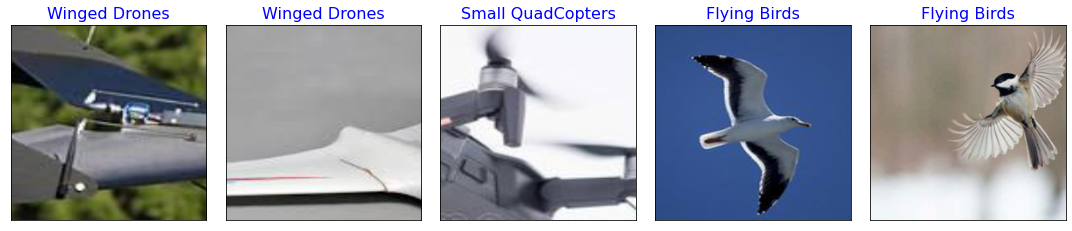

In [7]:
data.show_batch(save_as="sample.jpg")

# 4. Training Mobilenet Model - Only last layers
Modified last layer from 1000 classes to 4 and make only last layer trainable.
Here, we need to freeze all the network except the final layer. We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward().

In [8]:
import torch.optim as optim
#from torch_lr_finder import LRFinder

model_ft = models.mobilenet_v2(pretrained=True)
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).

for param in model_ft.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
model_ft.classifier[1] = nn.Linear(1280, 4)
model_ft = model_ft.to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/checkpoints/mobilenet_v2-b0353104.pth


Find hyper parameter lr value using LR Finder

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


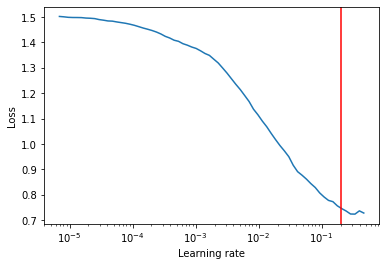

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.classifier[1].parameters(), lr=1e-6, weight_decay=0.01,momentum=0.9)
lr_finder = LRFinder(model_ft, optimizer, criterion, device="cuda")
lr_finder.range_test(data.dataloaders['train'], end_lr=10, num_iter=100)
lr_finder.plot(show_lr=0.2) # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial stat

In [10]:
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.classifier[1].parameters(), lr=0.01, momentum=0.09)

scheduler = optim.lr_scheduler.OneCycleLR(optimizer,
                                          max_lr=0.2, 
                                          steps_per_epoch=len(data.dataloaders['train']), #Training folder size/bs 
                                          epochs=15)

In [11]:
model_res, plotData = train_model(model_ft, data, device, criterion, optimizer_ft, scheduler,
                       num_epochs=15)

Epoch 0/14
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.8049 Acc: 0.7254
val Loss: 0.5123 Acc: 0.8514

Epoch 1/14
----------
train Loss: 0.5335 Acc: 0.8283
val Loss: 0.3972 Acc: 0.8745

Epoch 2/14
----------
train Loss: 0.4641 Acc: 0.8441
val Loss: 0.3548 Acc: 0.8792

Epoch 3/14
----------
train Loss: 0.4282 Acc: 0.8529
val Loss: 0.3202 Acc: 0.8915

Epoch 4/14
----------
train Loss: 0.4183 Acc: 0.8525
val Loss: 0.3193 Acc: 0.8896

Epoch 5/14
----------
train Loss: 0.4059 Acc: 0.8568
val Loss: 0.2935 Acc: 0.8973

Epoch 6/14
----------
train Loss: 0.3998 Acc: 0.8554
val Loss: 0.2868 Acc: 0.8994

Epoch 7/14
----------
train Loss: 0.3912 Acc: 0.8581
val Loss: 0.2766 Acc: 0.9021

Epoch 8/14
----------
train Loss: 0.3809 Acc: 0.8610
val Loss: 0.2757 Acc: 0.9021

Epoch 9/14
----------
train Loss: 0.3761 Acc: 0.8619
val Loss: 0.2741 Acc: 0.9021

Epoch 10/14
----------
train Loss: 0.3770 Acc: 0.8619
val Loss: 0.2754 Acc: 0.9009

Epoch 11/14
----------
train Loss: 0.3780 Acc: 0.8605
val Loss: 0.2629 Acc: 0.9079

Epoch 12/14
----------
t

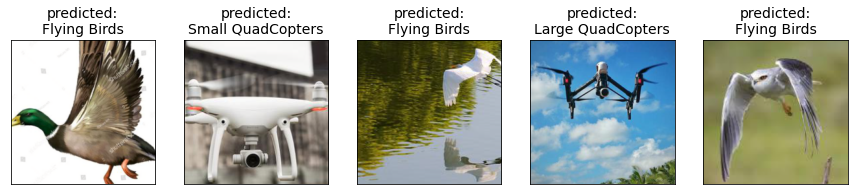

In [12]:
visualize_model(model_res, data, device,"visualize_1.jpg")

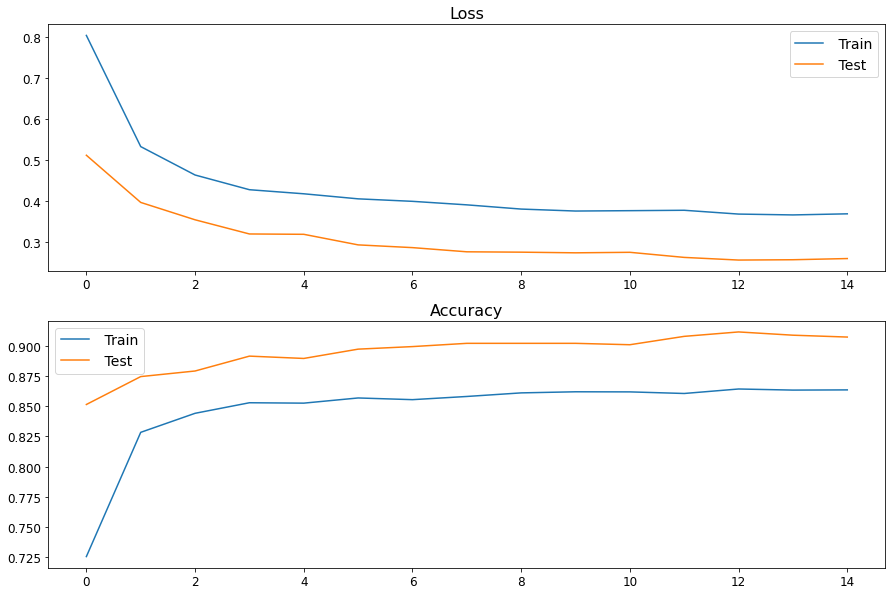

In [13]:
PlotGraph(plotData,"loss_accuracy_1.jpg")

#6. Finetuning the Model by Training all layers
Load a trained model and unfreeze all the layers. Train again to improve the accuracy. 

In [14]:
model_conv = model_res
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).

model_conv = model_conv.to(device)

for param in model_conv.parameters():
    param.requires_grad = True

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


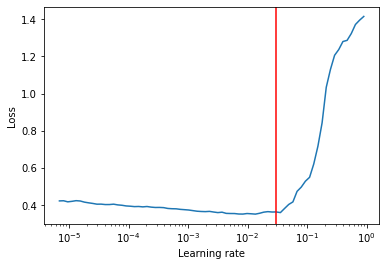

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_conv.parameters(), lr=1e-6, weight_decay=0.01,momentum=0.9)
lr_finder = LRFinder(model_conv, optimizer, criterion, device="cuda")
lr_finder.range_test(data.dataloaders['train'], end_lr=10, num_iter=100)
lr_finder.plot(show_lr=0.03) # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial stat

In [16]:
# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.parameters(), lr=0.001, momentum=0.9)

# One Cycle Policy
scheduler = optim.lr_scheduler.OneCycleLR(optimizer_conv,
                                          max_lr=0.03, 
                                          steps_per_epoch=len(data.dataloaders['train']), #Training folder size/bs
                                          epochs=25)

In [17]:
model_final, plotData = train_model(model_conv, data, device, criterion, optimizer_conv, scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.3312 Acc: 0.8719
val Loss: 0.1880 Acc: 0.9308

Epoch 1/24
----------
train Loss: 0.2867 Acc: 0.8918
val Loss: 0.1917 Acc: 0.9300

Epoch 2/24
----------
train Loss: 0.2946 Acc: 0.8910
val Loss: 0.1953 Acc: 0.9299

Epoch 3/24
----------
train Loss: 0.2810 Acc: 0.8956
val Loss: 0.2051 Acc: 0.9220

Epoch 4/24
----------
train Loss: 0.2951 Acc: 0.8913
val Loss: 0.2209 Acc: 0.9256

Epoch 5/24
----------
train Loss: 0.2944 Acc: 0.8897
val Loss: 0.1782 Acc: 0.9358

Epoch 6/24
----------
train Loss: 0.2882 Acc: 0.8952
val Loss: 0.2165 Acc: 0.9220

Epoch 7/24
----------
train Loss: 0.3361 Acc: 0.8759
val Loss: 0.3803 Acc: 0.8636

Epoch 8/24
----------
train Loss: 0.2451 Acc: 0.9115
val Loss: 0.1674 Acc: 0.9383

Epoch 9/24
----------
train Loss: 0.2182 Acc: 0.9186
val Loss: 0.2009 Acc: 0.9324

Epoch 10/24
----------
train Loss: 0.1977 Acc: 0.9269
val Loss: 0.2608 Acc: 0.9156

Epoch 11/24
----------
train Loss: 0.2265 Acc: 0.9148
val Loss: 0.1661 Acc: 0.9410

Ep

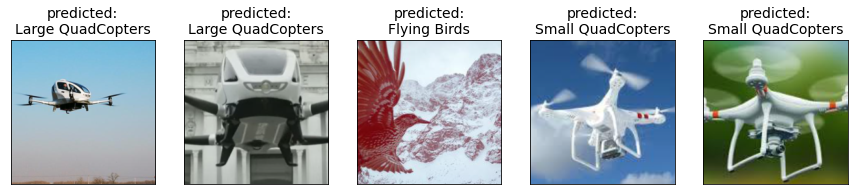

In [18]:
visualize_model(model_res, data, device,"visualize_2.jpg")
plt.ioff()
plt.show()

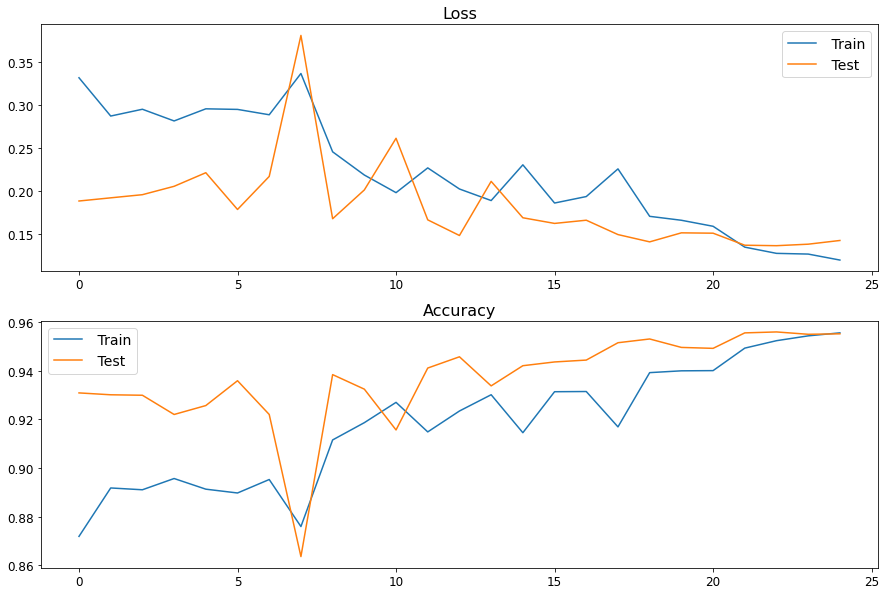

In [19]:
PlotGraph(plotData,"loss_accuracy_2.jpg")

# 7. Plotting Misclassified images

Miss-Classified Images in Flying Birds


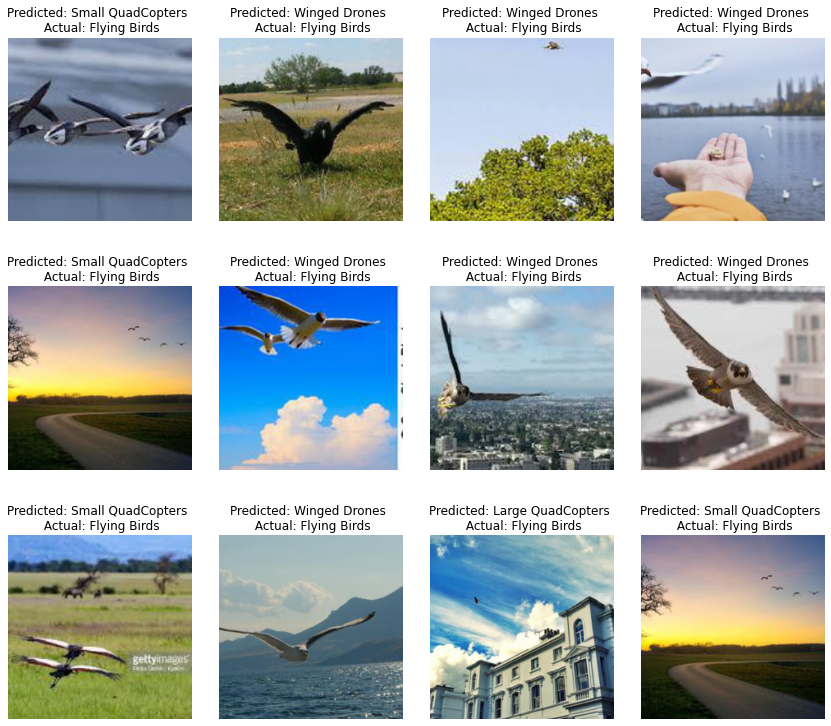

In [20]:
print("Miss-Classified Images in Flying Birds")
ShowMissclassifiedImages(model_final, data,0, device,save_as="MisclassifiedFlyingBirds.jpg")

Miss-Classified Images in Large Quadcopters


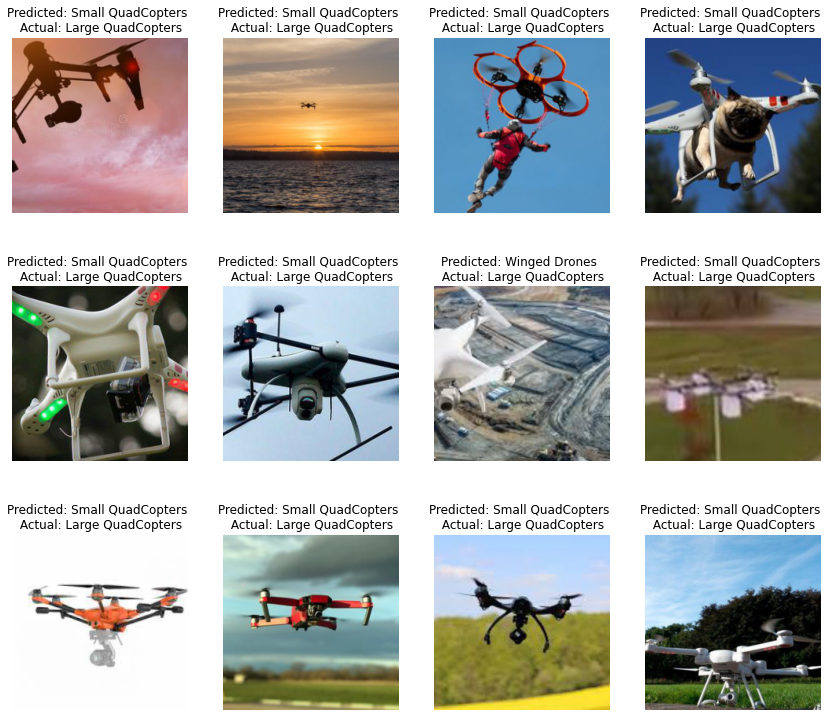

In [21]:
print("Miss-Classified Images in Large Quadcopters")
ShowMissclassifiedImages(model_final, data,1, device,save_as="MisclassifiedLargeQuadcopter.jpg")

Miss-Classified Images in Small Quadcopters


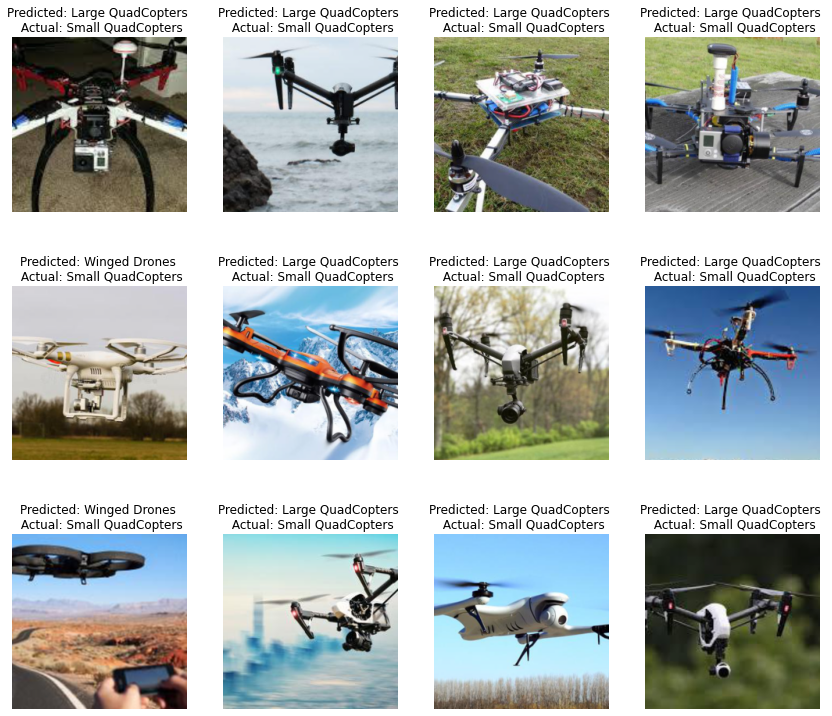

In [22]:
print("Miss-Classified Images in Small Quadcopters")
ShowMissclassifiedImages(model_final, data,2, device,save_as="MisclassifiedSmallQuadcopter.jpg")

Miss-Classified Images in Winged Drones


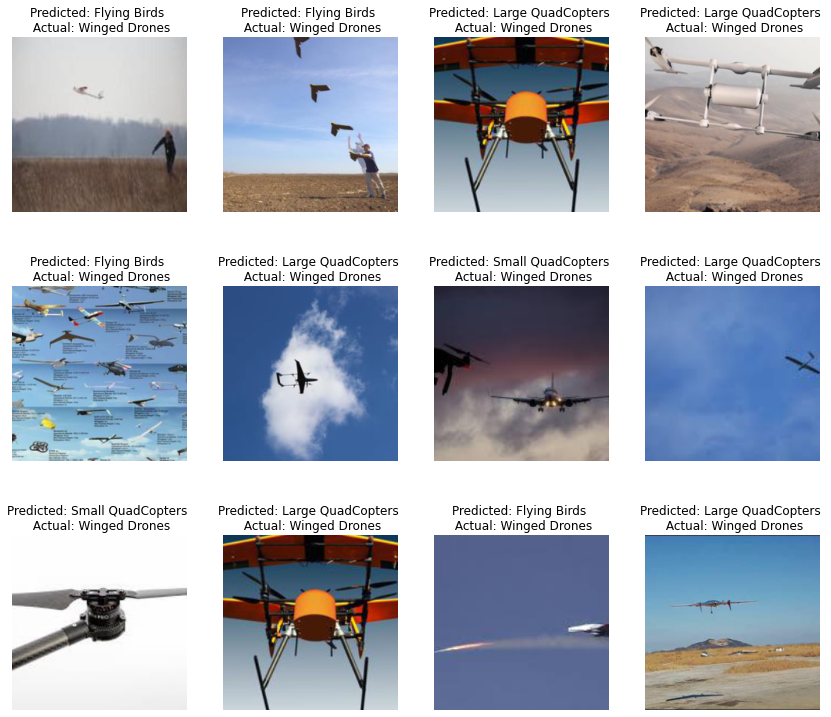

In [23]:
print("Miss-Classified Images in Winged Drones")
ShowMissclassifiedImages(model_final, data,3, device,save_as="MisclassifiedWingedDrones.jpg")

# 8. Saving Model

In [24]:
# Save GPU Model
torch.save(model_final.state_dict(), '/content/mobilenet_v2_custom_trained_gpu_v6.pt')

# Load CPU Model
device = torch.device('cpu')
model = models.mobilenet_v2(pretrained=False)
model.classifier[1] = nn.Linear(1280, 4)
model.load_state_dict(torch.load('/content/mobilenet_v2_custom_trained_gpu_v6.pt',
                                 map_location=device))

# Saving Trace Model
model.eval()
# trace model with a dummy input
traced_model = torch.jit.trace(model, torch.randn(1, 3, 224, 224))
traced_model.save('mobilenet_v2_custom_trained_v6.pt')